In [1]:
import multiprocessing as mp
import subprocess as sp
import tempfile as tmp
from typing import Literal, Optional, Tuple

import pandas as pd
from tqdm import tqdm

In [2]:
df_c = pd.read_pickle('./output/1_df_b_shaders-win-0924.pkl.zstd', compression='zstd')
df_p = pd.read_pickle('../performance/output/df_performance-win-0924.pkl.zstd', compression='zstd')
idx = df_p[df_p['status'] == 'Ok'].index
df = df_c[df_c.index_webapp.isin(idx)].copy()
df['type'] = df['type'].map(lambda x: 'vert' if x > 35632.5 else 'frag')
df.to_pickle('./output/df_shaders_joined-win-0924.pkl.zstd', compression='zstd')

In [3]:
a = df.groupby('type')['translatedSource']
a.nunique(), a.count()

(type
 frag    15512
 vert     7548
 Name: translatedSource, dtype: int64,
 type
 frag    46385
 vert    44039
 Name: translatedSource, dtype: int64)

In [4]:
NAGA = '/home/yudonghan/.cargo/bin/naga'
ANGLE = '/home/yudonghan/.local/bin/angle_shader_translator'
TINT = '/home/yudonghan/tint/out/Release/tint'
SPVAS = '/usr/bin/spirv-as'

In [5]:
def naga_compile(shader: str, type: Literal['vert', 'frag']) -> Tuple[str, bytes, bytes, int, Optional[str]]:
    with tmp.NamedTemporaryFile(suffix='.' + type) as tmpfile:
        with tmp.NamedTemporaryFile(mode='r+b', suffix='.wgsl') as tmpfile2:
            tmpfile.write(shader.encode())
            tmpfile.flush()
            cmd = [NAGA, tmpfile.name, tmpfile2.name, "--entry-point", 'main']
            process = sp.Popen(cmd, stdout=sp.PIPE, stderr=sp.PIPE)
            stdout, stderr = process.communicate()
            code = process.wait()
            wgsl = tmpfile2.read().decode()
            return ' '.join(cmd), stdout, stderr, code, wgsl

In [6]:
def angle_spirv(shader: str, type: Literal['vert', 'frag'], step2: Literal['naga', 'tint'], webgl_version: Literal[1, 2]) -> Tuple[str, bytes, bytes, int, Optional[str]]:
    swarg = '-s=w' if webgl_version == 1 else '-s=w2'
    with tmp.NamedTemporaryFile(suffix='.' + type) as tmpfile:
        tmpfile.write(shader.encode())
        tmpfile.flush()
        cmd = [ANGLE, swarg, '-b=v', '-o', '-u', tmpfile.name]
        process = sp.Popen(cmd, stdout=sp.PIPE, stderr=sp.PIPE)
        stdout, stderr = process.communicate()
        code = process.wait()
    if code != 0:
        return ' '.join(cmd), stdout, stderr, code, None
    t = stdout.splitlines()
    begin = t.index(b'#### BEGIN COMPILER 0 OBJ CODE ####')
    end = t.index(b'#### END COMPILER 0 OBJ CODE ####')
    spirv_asm = b'\n'.join(t[begin + 1: end])

    if step2=='naga':
        cmd = [SPVAS, '-o', '-', '-']
    else:
        cmd = [SPVAS, '--target-env', 'spv1.3', '-o', '-', '-']
    with tmp.NamedTemporaryFile(suffix='.spv') as tmpfile:
        process = sp.Popen(cmd, stdout=tmpfile, stderr=sp.PIPE, stdin=sp.PIPE)
        _, stderr = process.communicate(input=spirv_asm)
        code = process.wait()
        if code != 0:
            return ' '.join(cmd), stdout, stderr, code, None
        
        tmpfile.flush()
        with tmp.NamedTemporaryFile(mode='r+b', suffix='.wgsl') as tmpfile2:
            if step2 == 'naga':
                cmd = [NAGA, tmpfile.name, tmpfile2.name]
                process = sp.Popen(cmd, stdout=sp.PIPE, stderr=sp.PIPE)
                stdout, stderr = process.communicate()
                code = process.wait()
                if code != 0:
                    return ' '.join(cmd), stdout, stderr, code, None
                tmpfile2.seek(0)
                wgsl = tmpfile2.read().decode()
            else:
                cmd = [TINT, '--format', 'wgsl', '-o', '-', tmpfile.name]
                process = sp.Popen(cmd, stdout=sp.PIPE, stderr=sp.PIPE)
                stdout, stderr = process.communicate()
                code = process.wait()
                if code != 0:
                    return ' '.join(cmd), stdout, stderr, code, None
                wgsl = stdout.decode()
    return ' '.join(cmd), stdout, stderr, code, wgsl

In [7]:
def angle_glsl(shader: str, type: Literal['vert', 'frag'], step2: Literal['naga', 'tint'], webgl_version: Literal[1, 2]) -> Tuple[str, bytes, bytes, int, Optional[str]]:
    swarg = '-s=w' if webgl_version == 1 else '-s=w2'
    with tmp.NamedTemporaryFile(suffix='.' + type) as tmpfile:
        tmpfile.write(shader.encode())
        tmpfile.flush()
        cmd = [ANGLE, swarg, '-b=g440', '-o', '-u', tmpfile.name]
        process = sp.Popen(cmd, stdout=sp.PIPE, stderr=sp.PIPE)
        stdout, stderr = process.communicate()
        code = process.wait()
    if code != 0:
        return ' '.join(cmd), stdout, stderr, code, None
    t = stdout.splitlines()
    begin = t.index(b'#### BEGIN COMPILER 0 OBJ CODE ####')
    end = t.index(b'#### END COMPILER 0 OBJ CODE ####')
    glsl_code = b'\n'.join(t[begin + 1: end])

    with tmp.NamedTemporaryFile(suffix='.' + type if step2=='naga' else '.glsl') as tmpfile:
        tmpfile.write(glsl_code)
        tmpfile.flush()
        with tmp.NamedTemporaryFile(mode='r+b', suffix='.wgsl') as tmpfile2:
            if step2 == 'naga':
                cmd = [NAGA, tmpfile.name, tmpfile2.name]
                process = sp.Popen(cmd, stdout=sp.PIPE, stderr=sp.PIPE)
                stdout, stderr = process.communicate()
                code = process.wait()
                if code != 0:
                    return ' '.join(cmd), stdout, stderr, code, None
                tmpfile2.seek(0)
                wgsl = tmpfile2.read().decode()
            else:
                cmd = [TINT, '--format', 'wgsl', '-o', '-', tmpfile.name]
                process = sp.Popen(cmd, stdout=sp.PIPE, stderr=sp.PIPE)
                stdout, stderr = process.communicate()
                code = process.wait()
                if code != 0:
                    return ' '.join(cmd), stdout, stderr, code, None
                wgsl = stdout.decode()
    return ' '.join(cmd), stdout, stderr, code, wgsl

In [8]:
def getall(index_source_type: Tuple[int, str, Literal['vert', 'frag']]):
    idx, source, type = index_source_type
    naga_result = naga_compile(source, type)
    angle_webgl1_naga_glsl = angle_glsl(source, type=type, step2='naga', webgl_version=1)
    angle_webgl2_naga_glsl = angle_glsl(source, type=type, step2='naga', webgl_version=2)
    angle_webgl1_naga_spirv = angle_spirv(source, type=type, step2='naga', webgl_version=1)
    angle_webgl2_naga_spirv = angle_spirv(source, type=type, step2='naga', webgl_version=2)
    angle_webgl1_tint_spirv = angle_spirv(source, type=type, step2='tint', webgl_version=1)
    angle_webgl2_tint_spirv = angle_spirv(source, type=type, step2='tint', webgl_version=2)
    return [idx, type, source, *naga_result,
            *angle_webgl1_naga_glsl, *angle_webgl2_naga_glsl,
            *angle_webgl1_naga_spirv, *angle_webgl2_naga_spirv,
            *angle_webgl1_tint_spirv, *angle_webgl2_tint_spirv]

In [9]:
inputs = [[row.Index, row.source, row.type] for row in list(df.itertuples())]

In [10]:
with mp.Pool(32) as pool:
    results = list(tqdm(pool.imap_unordered(getall, inputs), total=len(inputs))) # type: ignore

100%|██████████| 90424/90424 [04:18<00:00, 349.63it/s]


In [61]:
df_compile = pd.DataFrame(results, columns=[
    'index_shader',
    'type',
    'source',
    'naga_cmd',
    'naga_stdout',
    'naga_stderr',
    'naga_code',
    'naga_wgsl',
    'angle_webgl1_naga_glsl_cmd',
    'angle_webgl1_naga_glsl_stdout',
    'angle_webgl1_naga_glsl_stderr',
    'angle_webgl1_naga_glsl_code',
    'angle_webgl1_naga_glsl_wgsl',
    'angle_webgl2_naga_glsl_cmd',
    'angle_webgl2_naga_glsl_stdout',
    'angle_webgl2_naga_glsl_stderr',
    'angle_webgl2_naga_glsl_code',
    'angle_webgl2_naga_glsl_wgsl',
    'angle_webgl1_naga_spirv_cmd',
    'angle_webgl1_naga_spirv_stdout',
    'angle_webgl1_naga_spirv_stderr',
    'angle_webgl1_naga_spirv_code',
    'angle_webgl1_naga_spirv_wgsl',
    'angle_webgl2_naga_spirv_cmd',
    'angle_webgl2_naga_spirv_stdout',
    'angle_webgl2_naga_spirv_stderr',
    'angle_webgl2_naga_spirv_code',
    'angle_webgl2_naga_spirv_wgsl',
    'angle_webgl1_tint_spirv_cmd',
    'angle_webgl1_tint_spirv_stdout',
    'angle_webgl1_tint_spirv_stderr',
    'angle_webgl1_tint_spirv_code',
    'angle_webgl1_tint_spirv_wgsl',
    'angle_webgl2_tint_spirv_cmd',
    'angle_webgl2_tint_spirv_stdout',
    'angle_webgl"2_tint_spirv_stderr',
    'angle_webgl2_tint_spirv_code',
    'angle_webgl2_tint_spirv_wgsl',
]).set_index('index_shader')
df_compile['index_webapp'] = df['index_webapp']

In [62]:
df_t = df_compile[[
    'index_webapp',
    'type',
    'naga_code',
]].copy()

df_t['angle_naga_glsl'] = df_compile['angle_webgl1_naga_glsl_code'] * df_compile['angle_webgl2_naga_glsl_code']
df_t['angle_naga_spirv'] = df_compile['angle_webgl1_naga_spirv_code'] * df_compile['angle_webgl2_naga_spirv_code']
df_t['angle_tint_spirv'] = df_compile['angle_webgl1_tint_spirv_code'] * df_compile['angle_webgl2_tint_spirv_code']
df_t

,index_webapp,type,naga_code,angle_naga_glsl,angle_naga_spirv,angle_tint_spirv
index_shader,,,,,,
1,2,frag,1,1,1,1
19,2,vert,1,1,0,1
12,2,vert,1,1,0,1
10,2,vert,1,1,0,1
14,2,vert,1,1,0,1
...,...,...,...,...,...,...
150198,29235,frag,1,1,1,1
150197,29235,vert,1,1,1,1
150204,29235,frag,1,1,1,1


In [82]:
tmp = df_t[['angle_naga_spirv', 'angle_naga_glsl', 'naga_code']]==0
tmp['type'] = df_t['type']
tmp = tmp[['type', 'angle_naga_spirv', 'angle_naga_glsl', 'naga_code']]
tmp.value_counts().sort_index()

type  angle_naga_spirv  angle_naga_glsl  naga_code
frag  False             False            False        35702
                        True             False          140
      True              False            False         7771
                        True             False         2767
                                         True             5
vert  False             False            False         4443
                        True             False            1
      True              False            False        37985
                        True             False         1609
                                         True             1
Name: count, dtype: int64

In [68]:
df_app = df_t.drop(columns=['type']).groupby('index_webapp').sum()
# df_app['overall'] = df_app.prod(axis=1)
df_app = df_app == 0

In [69]:
tt=df_app.sum(axis=0)

<Axes: title={'center': 'Number of shaders compiled successfully'}>

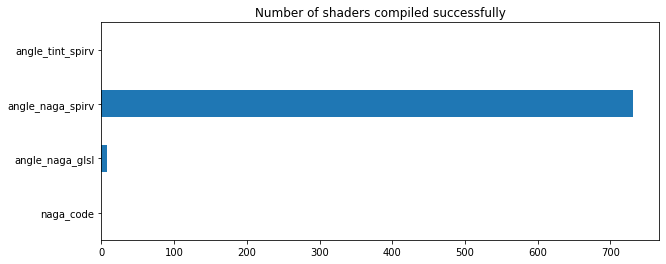

In [70]:
tt.plot(kind='barh', figsize=(10, 4), title='Number of shaders compiled successfully')

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
plt.bar(np.arange(len(tt)), tt.values, color="#ddd", edgecolor="black", hatch='//')
plt.xticks(np.arange(len(tt)), tt.index, rotation=70, ha='right')
plt.title('Texture Types', fontsize=14)

In [36]:
df_t[['naga_code', 'angle_naga_glsl', 'angle_naga_spirv', 'angle_tint_spirv']] = df_t[['naga_code', 'angle_naga_glsl', 'angle_naga_spirv', 'angle_tint_spirv']] == 0

In [37]:
df_t

,type,naga_code,angle_naga_glsl,angle_naga_spirv,angle_tint_spirv
0,frag,False,False,False,False
1,vert,False,False,True,False
2,vert,False,False,True,False
3,vert,False,False,True,False
4,vert,False,False,True,False
...,...,...,...,...,...
90419,frag,False,False,False,False
90420,vert,False,False,False,False
90421,frag,False,False,False,False
90422,vert,False,False,True,False


In [ ]:
sns.countplot(data=df_t, x='type', hue='type')

In [13]:
df_compile.to_pickle('./output/df_compile-win-1001.pkl.zstd', compression='zstd')

# ANALYZE

## WebAPP

In [16]:
# tmp = df_compile[['type', 'angle_naga_webgl2_code']].copy()
# tmp['angle_naga_webgl2_code'] = tmp['angle_naga_webgl2_code'].map(lambda x: 'Ok' if x == 0 else 'Err')
# tmp = tmp.value_counts().sort_index()
# # 2x2 grid

In [17]:
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(8, 3), sharey=True)
a = df_compile[df_compile.type=='vert'].dropna()['angle_naga_webgl2_wgsl'].map(lambda x: len(x)).to_numpy()
b = df_compile[df_compile.type=='vert'].dropna()['source'].map(lambda x: len(x)).to_numpy()
a = np.sort(a)
b = np.sort(b)
ax[0].grid()
ax[0].plot(a, np.arange(len(a)) / len(a), color='tab:blue')
ax[0].plot(b, np.arange(len(b)) / len(b), color='tab:red')
ax[0].set_xscale('log')
ax[0].set_ylabel('Fraction of Shaders', fontsize=14)
ax[0].set_xlabel('Length of a Vertex Shader (Byte)', fontsize=14)
# ax[0].legend(['WebGPU Shader', 'WebGL Shader'], fontsize=14)
a = df_compile[df_compile.type=='frag'].dropna()['angle_naga_webgl2_wgsl'].map(lambda x: len(x)).to_numpy()
b = df_compile[df_compile.type=='frag'].dropna()['source'].map(lambda x: len(x)).to_numpy()
a = np.sort(a)
b = np.sort(b)
ax[1].grid()
ax[1].plot(a, np.arange(len(a)) / len(a), color='tab:blue')
ax[1].plot(b, np.arange(len(b)) / len(b), color='tab:red')
ax[1].set_xscale('log')
# ax[1].set_ylabel('Fraction of Shaders', fontsize=14)
ax[1].set_xlabel('Length of a Fragment Shader (Byte)', fontsize=14)
ax[1].legend(['WebGPU Shader', 'WebGL Shader'], fontsize=14, ncol=2, loc='upper center', bbox_to_anchor=(-0.1, 1.22))
# plt.tight_layout()
plt.savefig('./output/fig/3_length.pdf', bbox_inches='tight')

In [ ]:
df_compile.naga_code.value_counts()

In [ ]:
df_compile.loc[100]